# Simulating and testing extractions of liquid crystal samples in quartz slides

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractorD, LayeredExtractorNK
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractorD, BayesianLayeredExtractorNK
import numpy as np

## Material params and reference pulse

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

t_axis = np.arange(0, L * deltat, deltat)

In [3]:
lambda_ = 3e8 / 1e12 # wavelength at 1THz
alpha_silica = 2.6
k_silica = - alpha_silica*lambda_/(4 * np.pi)
print(f'Silica k value: {k_silica}')
n_silica = 1.963
d_silica = 1e-3

k_lc = -0.0001
n1_lc = 1.5  # n in one orientation
n2_lc = 1.9  # n in second orientation
d_lc = 0.02e-3  # (20 microns)

lc_sample1 = [(n_silica+1j*k_silica, d_silica), (n1_lc+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]
lc_sample2 = [(n_silica+1j*k_silica, d_silica), (n2_lc+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]

Silica k value: -6.207042780583918e-05


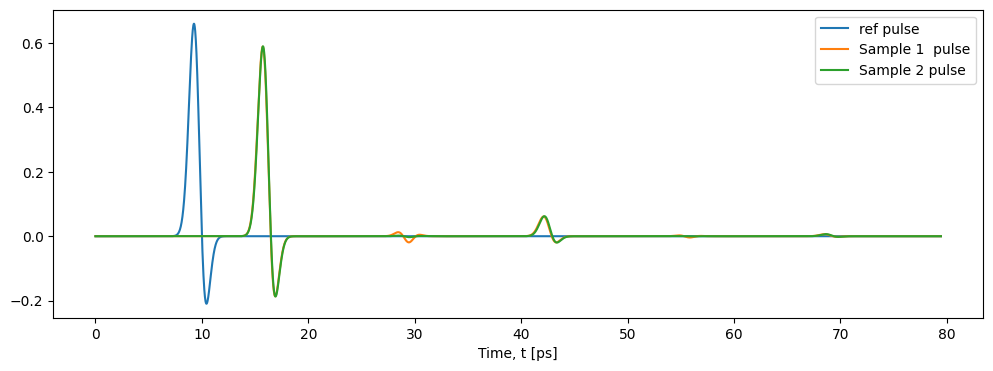

In [4]:
sample1_pulse = simulate_parallel(reference_pulse, lc_sample1, deltat, 0)[1][:L]
sample2_pulse = simulate_parallel(reference_pulse, lc_sample2, deltat, 0)[1][:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Sample 1  pulse')
plt.plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Sample 2 pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Try extract by checking all 3 layers as independent (can be changed) to see if we need to alter method to allow fixing of layers 

### Bayesian optimization for configuration 1

In [5]:
# set up initial guess for bayesian optimization
lc_sample1_init = [(n_silica+1j*k_silica, d_silica), (1.42+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]
# Initialize optimizer
lc1_bayesian_opt = BayesianLayeredExtractorNK(reference_pulse, sample1_pulse, deltat, lc_sample1_init)
# Perform Bayesian optimization
lc1_bayesian_layers = lc1_bayesian_opt.bayesian_optimization(n_calls=40) 
print(f'Bayesian layers for config 1: {lc1_bayesian_layers}')

Starting Bayesian Optimization for n and k...
Bayesian Optimization complete.
Bayesian layers for config 1: [((1.9543696063235616+0.009937929572194162j), 0.001), ((1.3487888990486074+0.0099j), 2e-05), ((1.974256709600681-0.010062070427805839j), 0.001)]


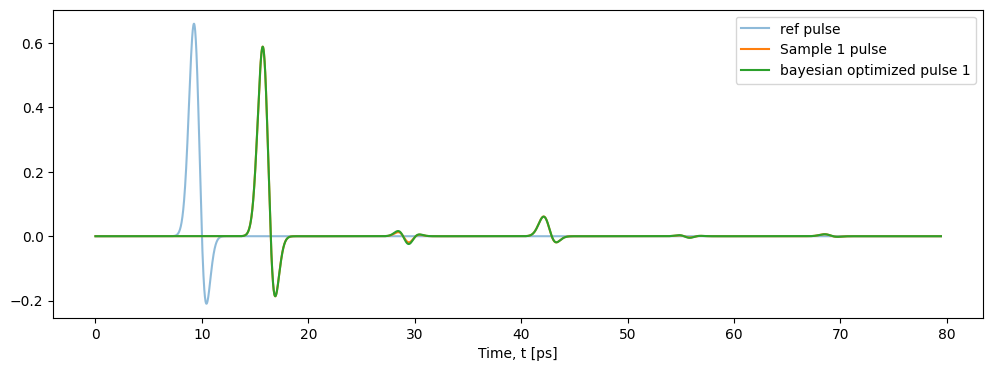

In [6]:
## Construct pulses with bayesian values
bayesian_pulse_1 = simulate_parallel(reference_pulse, lc1_bayesian_layers, deltat, 0)[1].detach().cpu().numpy()[:L]

# Plot reconstruction against 'experimental'
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis*1e12, sample1_pulse.detach().cpu().numpy(), label='Sample 1 pulse')
plt.plot(t_axis*1e12, bayesian_pulse_1, label='bayesian optimized pulse 1')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Bayesian optimization for configuration 2

In [7]:
# set up initial guess for bayesian optimization
lc_sample2_init = [(n_silica+1j*k_silica, d_silica), (1.82+1j*k_lc, d_lc), (n_silica+1j*k_silica, d_silica)]
# Initialize optimizer
lc2_bayesian_opt = BayesianLayeredExtractorNK(reference_pulse, sample2_pulse, deltat, lc_sample2_init)
# Perform Bayesian optimization
lc2_bayesian_layers = lc2_bayesian_opt.bayesian_optimization(n_calls=40) 
print(f'Bayesian layers for config 2: {lc2_bayesian_layers}')

Starting Bayesian Optimization for n and k...
Bayesian Optimization complete.
Bayesian layers for config 2: [((2.063+0.006278157710214789j), 0.001), ((1.8297991304450563-0.009501991082946974j), 2e-05), ((1.863-0.00300512571888481j), 0.001)]


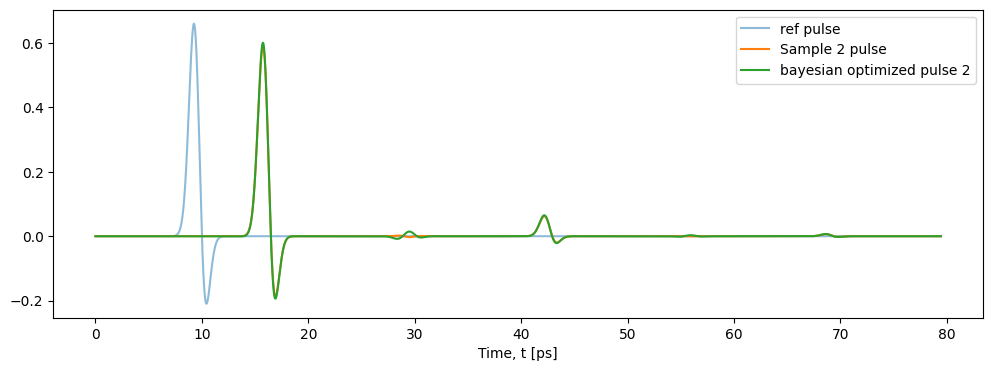

In [8]:
## Construct pulses with bayesian values
bayesian_pulse_2 = simulate_parallel(reference_pulse, lc2_bayesian_layers, deltat, 0)[1].detach().cpu().numpy()[:L]

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis*1e12, sample2_pulse.detach().cpu().numpy(), label='Sample 2 pulse')
plt.plot(t_axis*1e12, bayesian_pulse_2, label='bayesian optimized pulse 2')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Gradient Descent optimization on configuration 1

In [9]:
LC1_optimizer = LayeredExtractorNK(reference_pulse, sample1_pulse, deltat, lc1_bayesian_layers)
lc1_layers_opt = LC1_optimizer.optimize(num_iterations=50)
print(lc1_layers_opt)

Optimizing for 50 iterations with loss multiplier 1.
Iteration 9, Loss: 0.0021288252901285887, Layer 0: n=1.9536669254302979, k=0.00926870945841074, D=0.001, Layer 1: n=1.3556787967681885, k=0.010506457649171352, D=2e-05, Layer 2: n=1.9738725423812866, k=-0.010341187007725239, D=0.001
Iteration 19, Loss: 0.0020681628957390785, Layer 0: n=1.9534804821014404, k=0.009033006615936756, D=0.001, Layer 1: n=1.3631649017333984, k=0.011956688016653061, D=2e-05, Layer 2: n=1.9742108583450317, k=-0.010005281306803226, D=0.001
Iteration 29, Loss: 0.0020810356363654137, Layer 0: n=1.9532206058502197, k=0.008924813941121101, D=0.001, Layer 1: n=1.3709934949874878, k=0.013601882383227348, D=2e-05, Layer 2: n=1.9745672941207886, k=-0.009495881386101246, D=0.001
Iteration 39, Loss: 0.0020594282541424036, Layer 0: n=1.9529300928115845, k=0.008704441599547863, D=0.001, Layer 1: n=1.3789089918136597, k=0.0150044159963727, D=2e-05, Layer 2: n=1.974967360496521, k=-0.009095084853470325, D=0.001
Iteration 49